In [271]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import AffinityPropagation, DBSCAN, KMeans

In [229]:
dataset = pd.read_csv('../../data/mice_protein/mice_protein.csv')
dataset.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


In [230]:
for column in dataset.columns:
    print(dataset[column].isna().sum(), len(dataset), column)

0 1080 MouseID
3 1080 DYRK1A_N
3 1080 ITSN1_N
3 1080 BDNF_N
3 1080 NR1_N
3 1080 NR2A_N
3 1080 pAKT_N
3 1080 pBRAF_N
3 1080 pCAMKII_N
3 1080 pCREB_N
3 1080 pELK_N
3 1080 pERK_N
3 1080 pJNK_N
3 1080 PKCA_N
3 1080 pMEK_N
3 1080 pNR1_N
3 1080 pNR2A_N
3 1080 pNR2B_N
3 1080 pPKCAB_N
3 1080 pRSK_N
3 1080 AKT_N
3 1080 BRAF_N
3 1080 CAMKII_N
3 1080 CREB_N
18 1080 ELK_N
3 1080 ERK_N
3 1080 GSK3B_N
3 1080 JNK_N
7 1080 MEK_N
3 1080 TRKA_N
3 1080 RSK_N
3 1080 APP_N
18 1080 Bcatenin_N
3 1080 SOD1_N
3 1080 MTOR_N
3 1080 P38_N
3 1080 pMTOR_N
3 1080 DSCR1_N
3 1080 AMPKA_N
3 1080 NR2B_N
3 1080 pNUMB_N
3 1080 RAPTOR_N
3 1080 TIAM1_N
3 1080 pP70S6_N
0 1080 NUMB_N
0 1080 P70S6_N
0 1080 pGSK3B_N
0 1080 pPKCG_N
0 1080 CDK5_N
0 1080 S6_N
0 1080 ADARB1_N
0 1080 AcetylH3K9_N
0 1080 RRP1_N
0 1080 BAX_N
0 1080 ARC_N
0 1080 ERBB4_N
0 1080 nNOS_N
0 1080 Tau_N
0 1080 GFAP_N
0 1080 GluR3_N
0 1080 GluR4_N
0 1080 IL1B_N
0 1080 P3525_N
0 1080 pCASP9_N
0 1080 PSD95_N
0 1080 SNCA_N
0 1080 Ubiquitin_N
0 1080 pGSK3B_Tyr216_

In [231]:
numeric_columns = dataset._get_numeric_data().columns
categorical_columns = list(set(dataset.columns) - set(numeric_columns))
print(categorical_columns)

['MouseID', 'class', 'Genotype', 'Behavior', 'Treatment']


In [232]:
# Target feature is a combination of treatment and behavior features. It can take 4 different values.
dataset['target'] = dataset['Treatment'] + dataset['Behavior']

In [233]:
for column in {'target', 'Genotype'}:
    nan_count = dataset[column].isna().sum()
    distribution = dataset[column].value_counts(normalize=True)
    missing = dataset[column].isnull()
    dataset.loc[missing, column] = np.random.choice(distribution.index, size=len(dataset[missing]), p=distribution.values)

In [234]:
for column in numeric_columns:
    dataset[column] = dataset[column].fillna(dataset[column].median())

<Axes: >

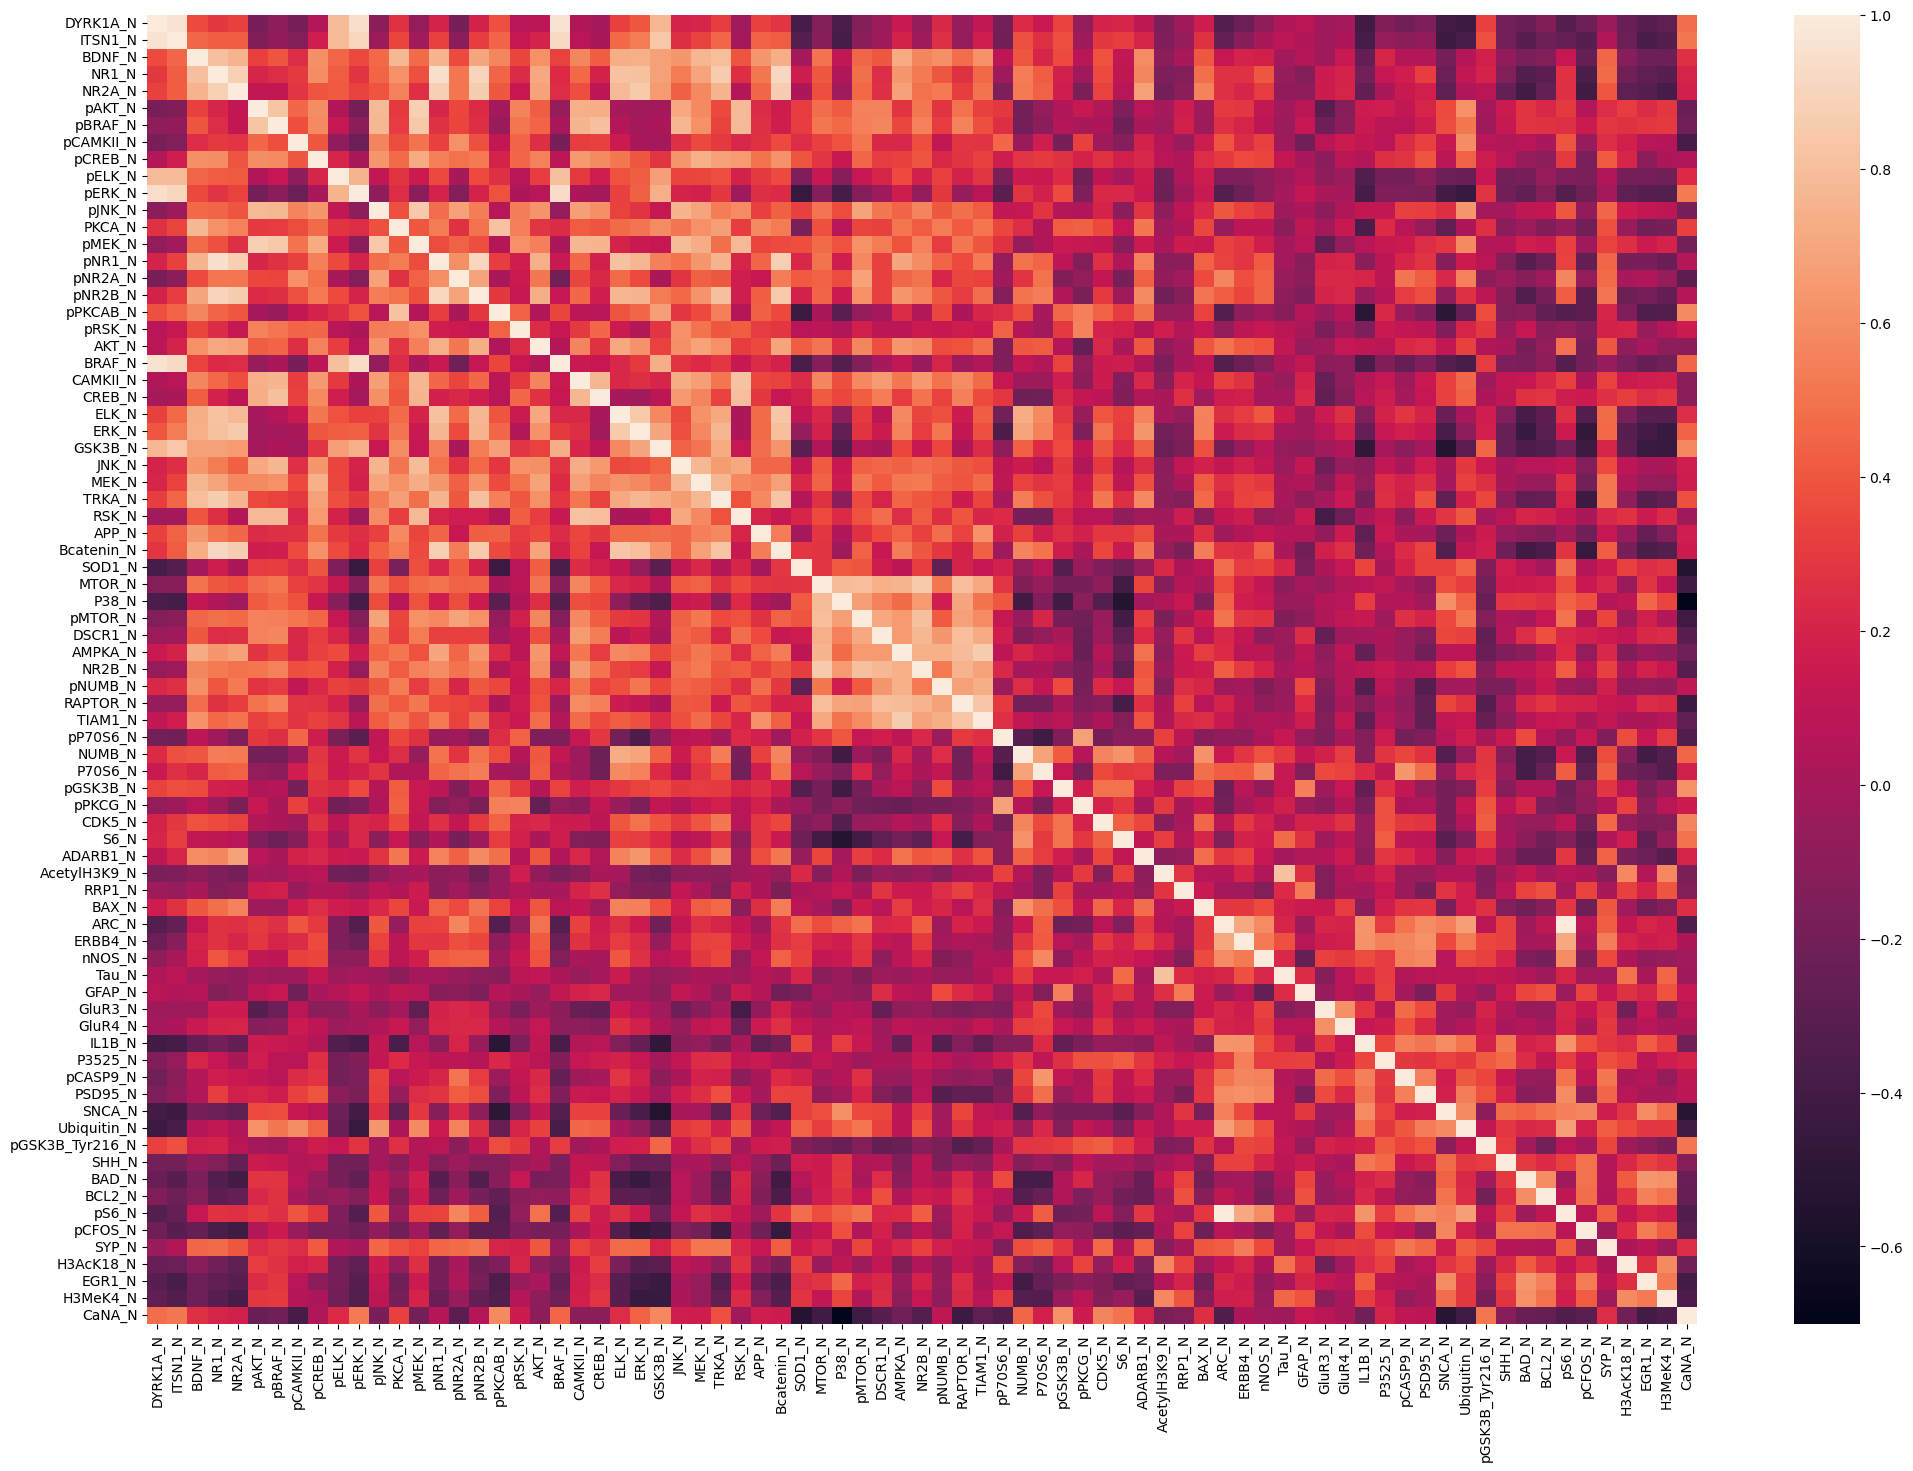

In [235]:
corr_matrix = dataset[numeric_columns].corr()
plt.figure(figsize=(25, 17))
sns.heatmap(corr_matrix)

<Axes: >

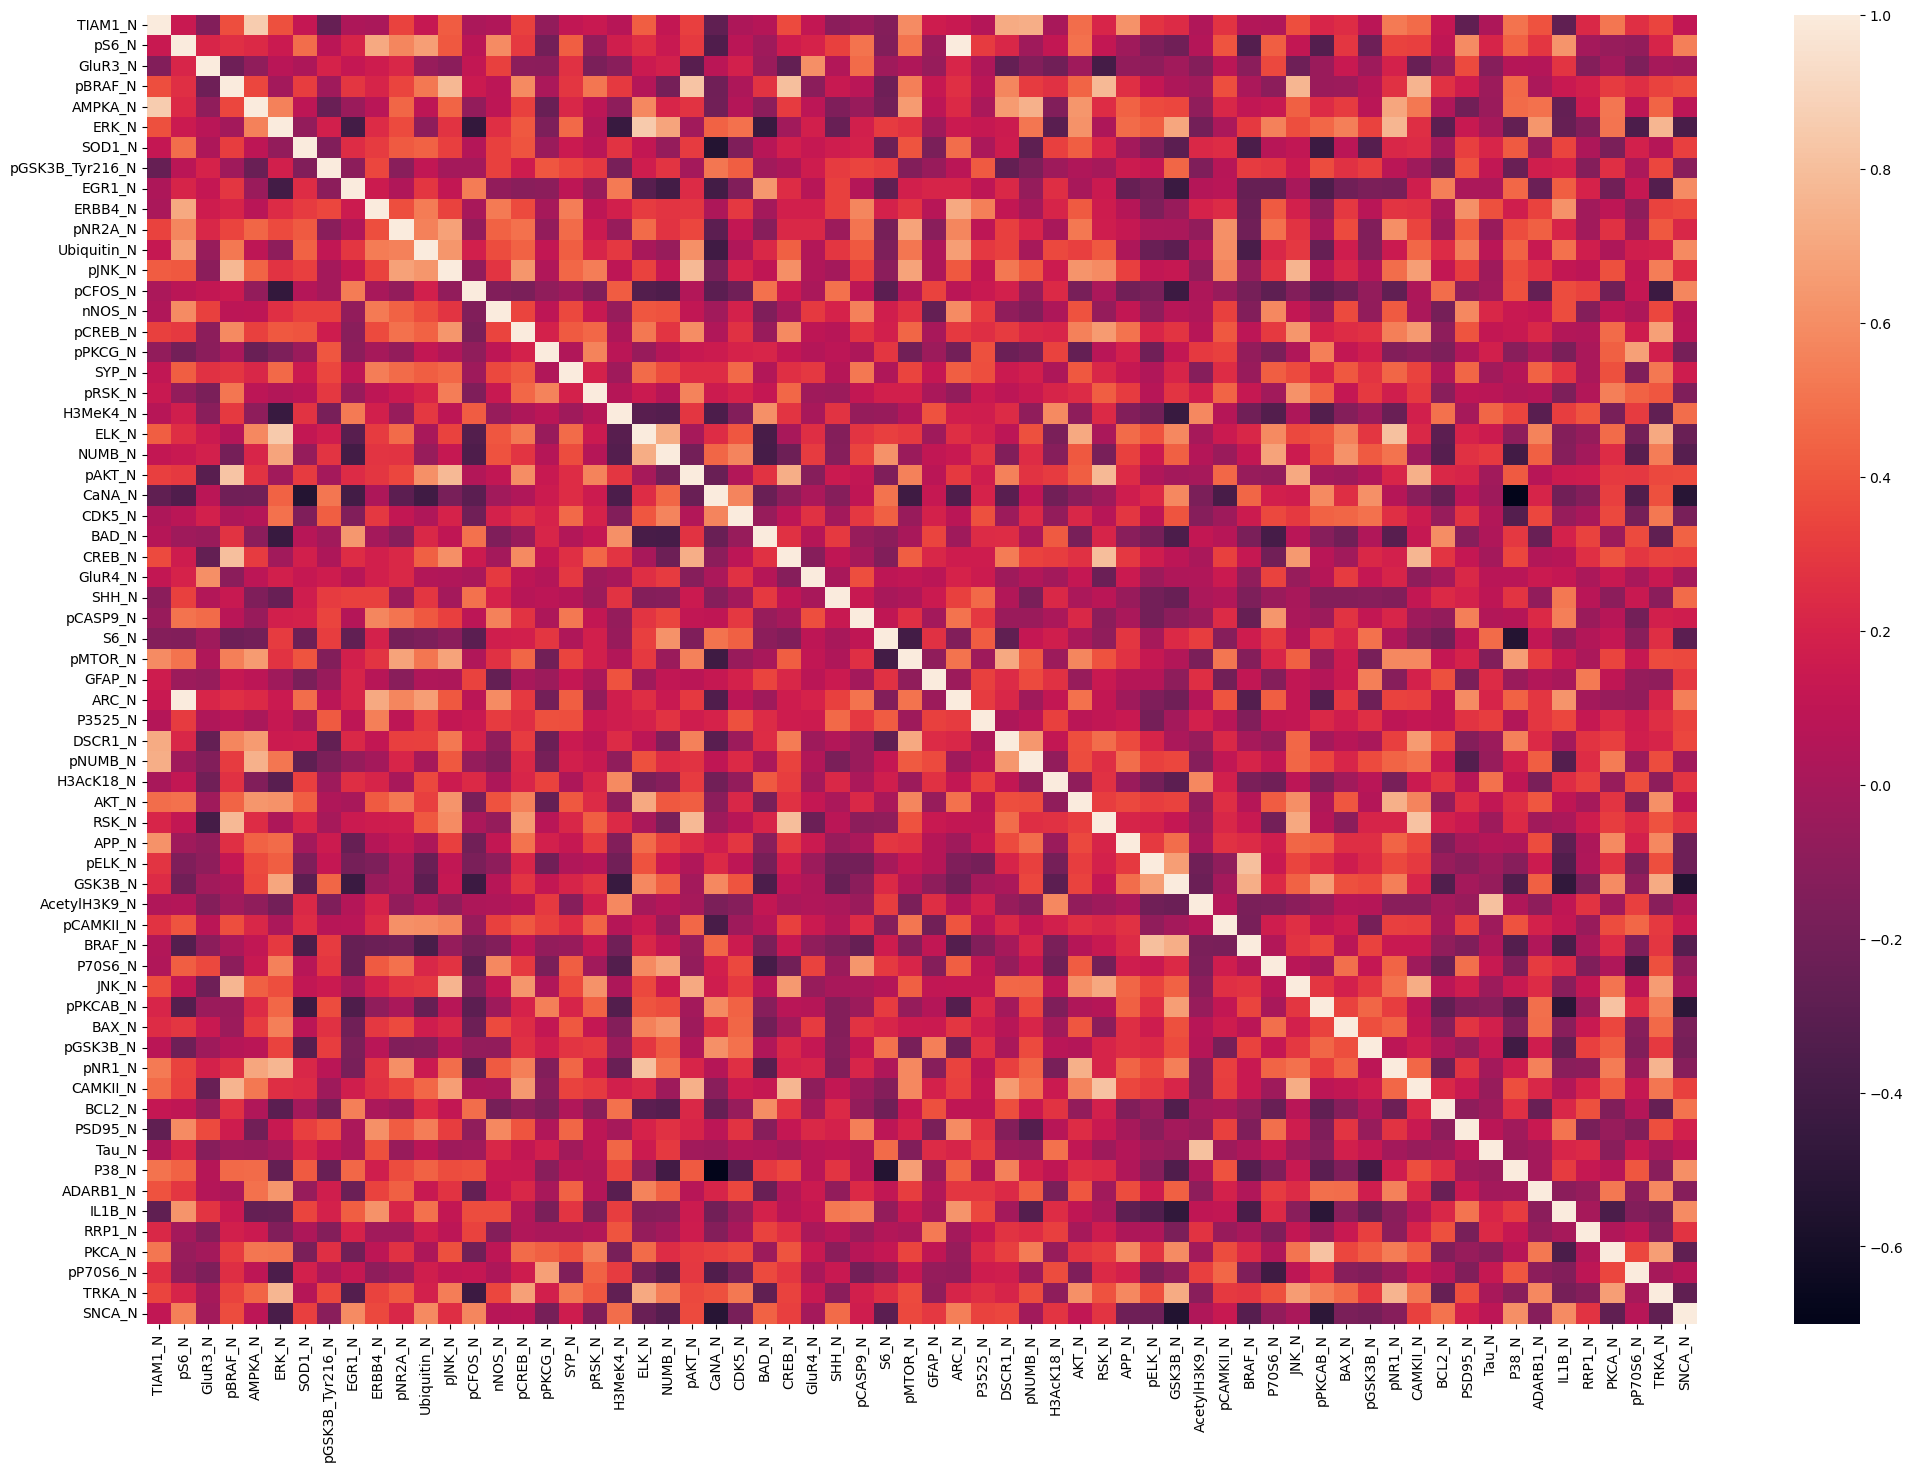

In [236]:
numeric_columns = list(set(numeric_columns) - {'DYRK1A_N', 'NR2A_N', 'NR1_N', 'ITSN1_N', 'Bcatenin_N', 'BDNF_N', 'pNR2B_N', 'pERK_N', 'pMEK_N', 'MEK_N', 'RAPTOR_N', 'NR2B_N', 'MTOR_N', 'Humidity9am'})
corr_matrix = dataset[numeric_columns].corr()
plt.figure(figsize=(25, 17))
sns.heatmap(corr_matrix)

In [237]:
prev_columns_count = len(dataset.columns)
columns_to_delete = {'DYRK1A_N', 'NR2A_N', 'NR1_N', 'ITSN1_N', 'Bcatenin_N', 'BDNF_N', 'pNR2B_N', 'pERK_N', 'pMEK_N', 'MEK_N', 'RAPTOR_N', 'NR2B_N', 'MTOR_N'}
new_columns = list(set(dataset.columns) - columns_to_delete)
dataset = dataset[new_columns]
print(f'Deleted {prev_columns_count - len(dataset.columns)} highly correlated columns')

Deleted 13 highly correlated columns


In [238]:
# Info about "target" feature is encoded in "class" feature, so I delete it here
dataset = dataset.drop(['Treatment', 'Behavior', 'MouseID', 'class'], axis=1)

In [239]:
X = dataset.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, dataset['target'], test_size=0.1, random_state=42)

In [240]:
ordinal_encoder = OrdinalEncoder()
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)
y_train = ordinal_encoder.fit_transform(y_train)
y_test = ordinal_encoder.transform(y_test)
y_train = y_train.reshape(972,)
y_test = y_test.reshape(108,)

In [242]:
numeric_columns = X_train._get_numeric_data().columns
categorical_columns = list(set(X_train.columns) - set(numeric_columns))
X_train[categorical_columns] = ordinal_encoder.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = ordinal_encoder.transform(X_test[categorical_columns])

In [243]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [156]:
y_t = pd.Series(y_train)
y_t.value_counts()

1.0    266
0.0    256
3.0    234
2.0    216
Name: count, dtype: int64

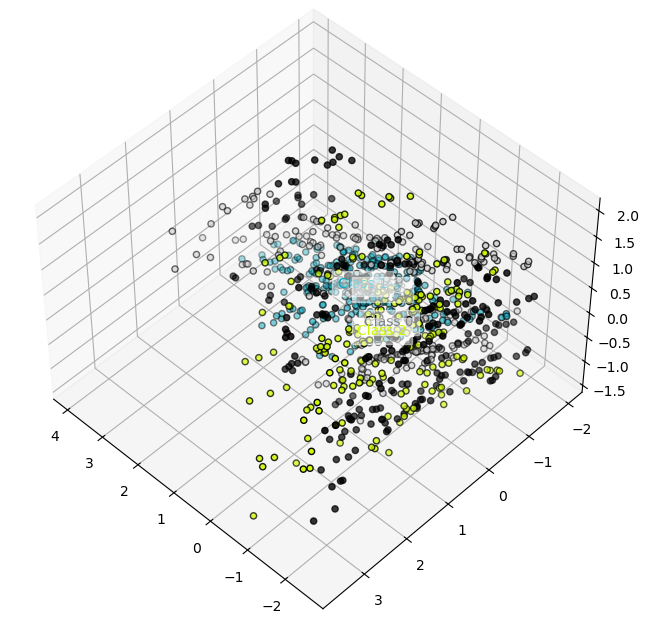

In [244]:
from sklearn.decomposition import PCA
fig = plt.figure(1, figsize=(8, 6))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])


plt.cla()
pca = PCA(n_components=3)
X_train_3d = pca.fit_transform(X_train)
class_names = ["Class 0", "Class 1", "Class 2", "Class 3"]

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 4)) # Create 8 distinct colors

for label, name in enumerate(class_names):
    ax.text3D(
        X_train_3d[y_train == label, 0].mean(),
        X_train_3d[y_train == label, 1].mean(),
        X_train_3d[y_train == label, 2].mean(),
        name,
        color=colors[label],
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )

ax.scatter(X_train_3d[:, 0], X_train_3d[:, 1], X_train_3d[:, 2], c=[colors[int(i)] for i in y_train], edgecolor="k")

C:\Users\Михаил\AppData\Local\Temp\ipykernel_14884\1445884134.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  alpha=0.7, s=20, cmap=plt.cm.get_cmap('nipy_spectral', 4))


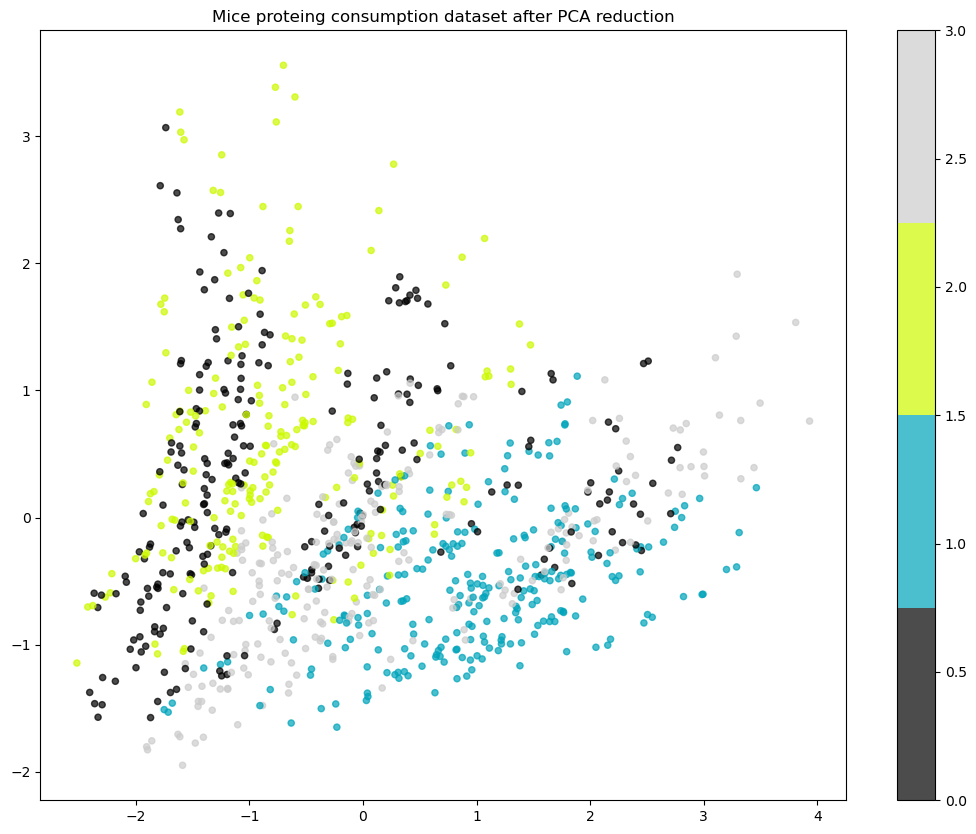

In [245]:
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
xs = X_train_2d[:, 0]
ys = X_train_2d[:, 1]

plt.figure(figsize=(13,10))
plt.scatter(xs, ys, c=y_train.astype(int),
            alpha=0.7, s=20, cmap=plt.cm.get_cmap('nipy_spectral', 4))
plt.colorbar()
plt.title('Mice proteing consumption dataset after PCA reduction');

C:\Users\Михаил\AppData\Local\Temp\ipykernel_14884\2127237603.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("nipy_spectral", 4),


Text(0.5, 1.0, 'Mice proteing consumption dataset after t-SNE reduction')

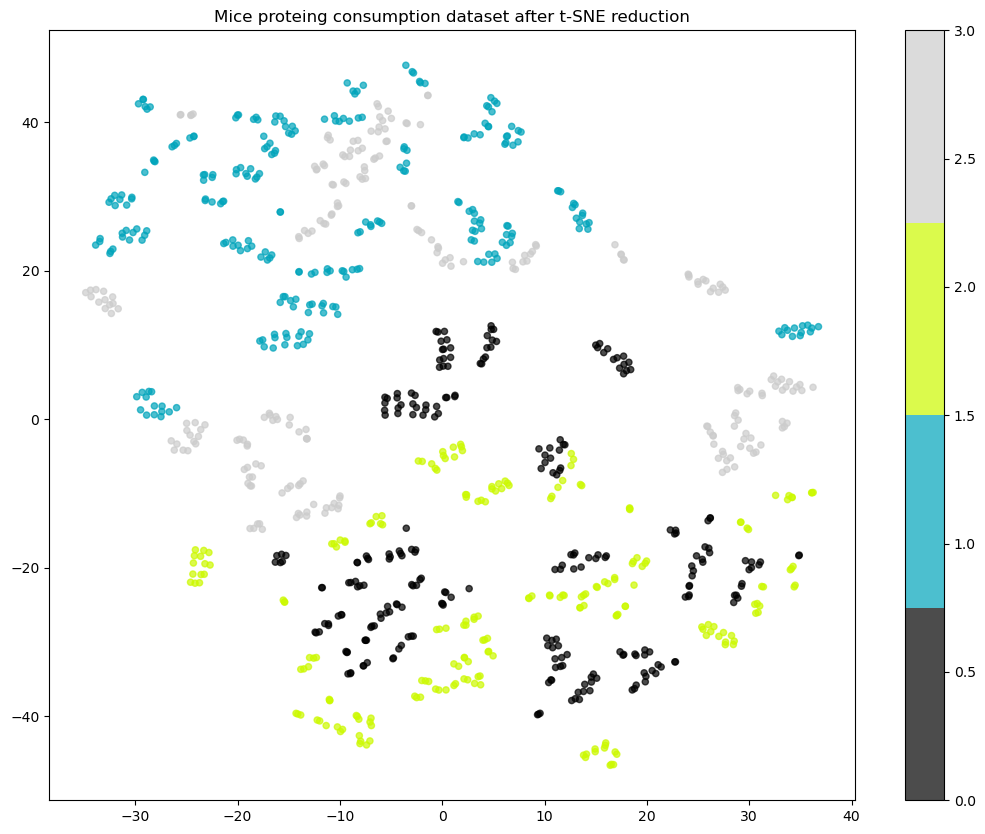

In [246]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)
xs = X_tsne[:, 0]
ys = X_tsne[:, 1]

plt.figure(figsize=(13, 10))
plt.scatter(
    xs,
    ys,
    c=y_train,
    alpha=0.7,
    s=20,
    cmap=plt.cm.get_cmap("nipy_spectral", 4),
)
plt.colorbar()
plt.title("Mice proteing consumption dataset after t-SNE reduction")

Из визуализаций видно, что объекты одного класса не кучкуются в одном месте, а все перемешаны между собой. Поэтому задача кластеризации на данном датасете может быть довольно сложна.

In [160]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=4, n_iterations=500):
        self.n_clusters = n_clusters
        self.n_iterations = n_iterations
        self.clusters = None

    
    def distance_func(self, p1, p2):
        return np.sqrt(np.sum((p1 - p2) ** 2))

    def _initialize_clusters(self, features_number):
        self.clusters = {}
        np.random.seed(23)
        
        for idx in range(self.n_clusters):
            center = 2 * (2 * np.random.random((features_number,)) - 1)
            cluster = {
                'center' : center,
                'points' : []
            }
            
            self.clusters[idx] = cluster

    def _assign_clusters(self, X):
        for idx in range(X.shape[0]):
            distances = []
            
            point = X[idx]
        
            for i in range(self.n_clusters):
                distance = self.distance_func(point, self.clusters[i]['center'])
                distances.append(distance)

            point_cluster = np.argmin(distances)
            self.clusters[point_cluster]['points'].append(point)
         
    def _update_clusters(self, X):
        for i in range(self.n_clusters):
            points = np.array(self.clusters[i]['points'])
            if points.shape[0] > 0:
                new_center = points.mean(axis=0)
                self.clusters[i]['center'] = new_center
                
                self.clusters[i]['points'] = []
     

    def fit(self, X, y=None):
        self._initialize_clusters(X.shape[1])
        for _ in range(self.n_iterations):
            self._assign_clusters(X)
            self._update_clusters(X)

    def predict(self, X):
        pred = []
        if self.n_clusters is None or self.clusters is None:
            return None
        for i in range(X.shape[0]):
            distances = []
            for j in range(self.n_clusters):
                distance = self.distance_func(X[i], self.clusters[j]['center'])
                distances.append(distance)
            pred.append(np.argmin(distances))
        return pred

In [250]:
data = dict()

for n_components in [20, 40]:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    data[f'X_train_{n_components}'] = X_train_pca
    data[f'X_test_{n_components}'] = X_test_pca

In [305]:
def get_model_score(model, params, X_train, X_test, conf_matrix=False, db_scan=False):
    grid_search = GridSearchCV(model, params, scoring='adjusted_mutual_info_score', cv=3, n_jobs=-1)
    grid_search.fit(X_train)
    
    model = model.set_params(**grid_search.best_params_)
    start = datetime.now()
    if db_scan:
        predictions = model.fit_predict(X_train)
        true_vals = y_train
    else:
        model.fit(X_train)
        predictions = model.predict(X_test)
        true_vals = y_test
    end = datetime.now()


    adj_rand_score = adjusted_rand_score(true_vals, predictions)
    adj_mut_info_score = adjusted_mutual_info_score(true_vals, predictions)
    homogen_score = homogeneity_score(true_vals, predictions)
    comp_score = completeness_score(true_vals, predictions)

    scores = dict()
    scores['adj_rand_score'] = adj_rand_score
    scores['adj_mut_info_score'] = adj_mut_info_score
    scores['homogen_score'] = homogen_score
    scores['comp_score'] = comp_score
    scores['training_time'] = end - start

    if conf_matrix:
        cm = confusion_matrix(true_vals, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    return scores

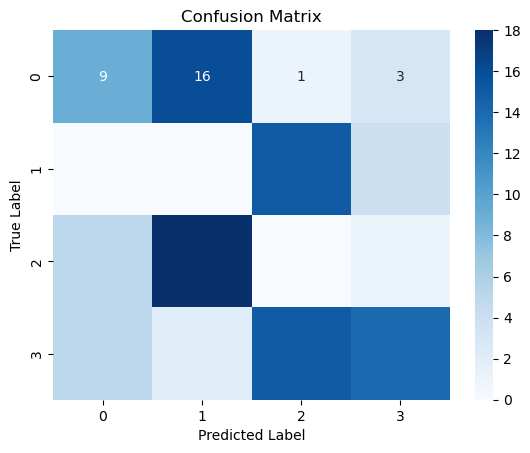

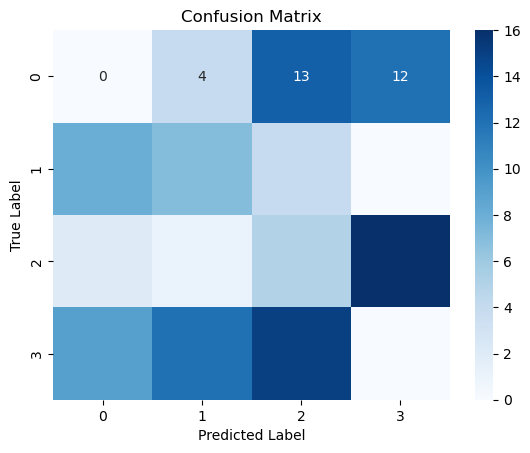

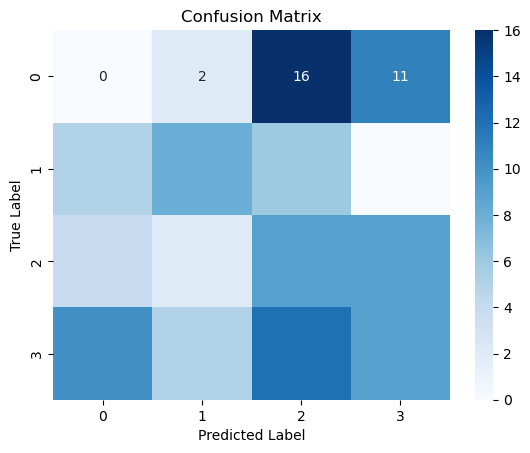

,adj_rand_score,adj_mut_info_score,homogen_score,comp_score,training_time,model,pca
0,0.231308,0.305519,0.327396,0.328586,0 days 00:00:00.186162,MyKMeans,no_pca
1,0.145172,0.221605,0.246542,0.246959,0 days 00:00:00.138180,MyKMeans,20
2,0.044268,0.094749,0.122678,0.126661,0 days 00:00:00.036073,MyKMeans,40


In [296]:
model = MyKMeans(n_clusters=4)
params = {
    'n_iterations': np.logspace(0, 10, base=2.0, num=10, dtype=int)
}
non_pca_score = get_model_score(model, params, X_train.to_numpy(), X_test.to_numpy(), conf_matrix=True)
pca_20_score = get_model_score(model, params, data['X_train_20'], data['X_test_20'], conf_matrix=True)
pca_40_score = get_model_score(model, params, data['X_train_40'], data['X_test_40'], conf_matrix=True)

results = [non_pca_score, pca_20_score, pca_40_score]
df_my_kmeans = pd.DataFrame.from_records(results)
df_my_kmeans['model'] = 'MyKMeans'
df_my_kmeans['pca'] = ['no_pca', '20', '40']
df_my_kmeans

c:\ML\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ML\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


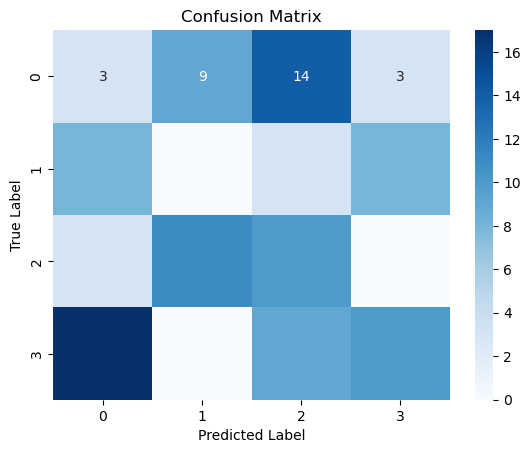

c:\ML\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ML\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


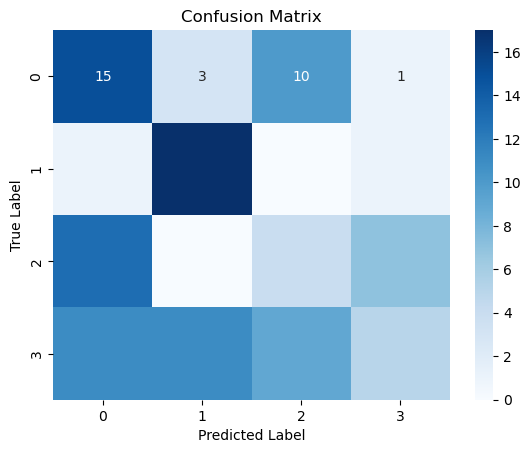

c:\ML\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ML\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


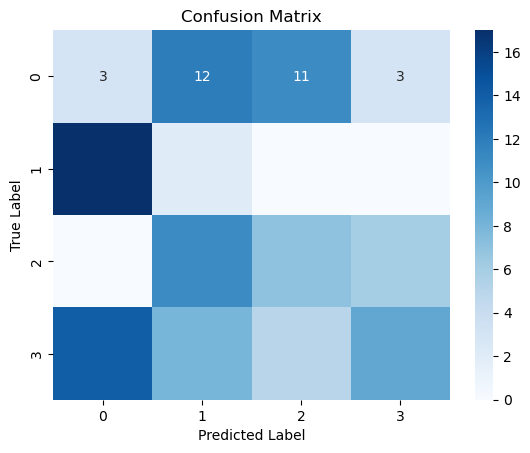

,adj_rand_score,adj_mut_info_score,homogen_score,comp_score,training_time,model,pca
0,0.116068,0.185346,0.211376,0.212003,0 days 00:00:00.071395,sk_learn_KMeans,no_pca
1,0.126012,0.193937,0.217421,0.223819,0 days 00:00:00.062502,sk_learn_KMeans,20
2,0.123306,0.191276,0.217051,0.217865,0 days 00:00:00.073598,sk_learn_KMeans,40


In [297]:
params = {
    'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0],
    'init': ['random', 'k-means++'],
    'max_iter': [100, 500, 1000, 2000],
}
model = KMeans(n_clusters=4)

non_pca_score = get_model_score(model, params, X_train, X_test, conf_matrix=True)
pca_20_score = get_model_score(model, params, data['X_train_20'], data['X_test_20'], conf_matrix=True)
pca_40_score = get_model_score(model, params, data['X_train_40'], data['X_test_40'], conf_matrix=True)
results = [non_pca_score, pca_20_score, pca_40_score]
df_kmeans = pd.DataFrame.from_records(results)
df_kmeans['model'] = 'sk_learn_KMeans'
df_kmeans['pca'] = ['no_pca', '20', '40']
df_kmeans

In [300]:
params = {
    'max_iter': np.logspace(start=6, stop=10, num=5, base=2.0, dtype=int),
    'damping': np.arange(0.5, 0.9, step=0.1),
    'convergence_iter': np.arange(5, 25, step=4),
}

model = AffinityPropagation()

non_pca_score = get_model_score(model, params, X_train, X_test)
pca_20_score = get_model_score(model, params, data['X_train_20'], data['X_test_20'])
pca_40_score = get_model_score(model, params, data['X_train_40'], data['X_test_40'])

results = [non_pca_score, pca_20_score, pca_40_score]
df_affinity = pd.DataFrame.from_records(results)
df_affinity['model'] = 'AffinityPropagation'
df_affinity['pca'] = ['no_pca', '20', '40']
df_affinity

,adj_rand_score,adj_mut_info_score,homogen_score,comp_score,training_time,model,pca
0,0.068805,0.231119,0.868961,0.312490,0 days 00:00:00.474083,AffinityPropagation,no_pca
1,0.042500,0.189728,0.939773,0.312861,0 days 00:00:00.341778,AffinityPropagation,20
2,0.036128,0.180168,0.951531,0.311825,0 days 00:00:00.752130,AffinityPropagation,40


In [301]:
params = {
    'eps': np.arange(0.25, 1.0, step=0.05),
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'min_samples': np.arange(2, 10, step=1),
}

model = DBSCAN()

non_pca_score = get_model_score(model, params, X_train, X_test, db_scan=True)
pca_20_score = get_model_score(model, params, data['X_train_20'], data['X_test_20'], db_scan=True)
pca_40_score = get_model_score(model, params, data['X_train_40'], data['X_test_40'], db_scan=True)

results = [non_pca_score, pca_20_score, pca_40_score]
df_dbscan = pd.DataFrame.from_records(results)
df_dbscan['model'] = 'DBSCAN'
df_dbscan['pca'] = ['no_pca', '20', '40']
df_dbscan

,adj_rand_score,adj_mut_info_score,homogen_score,comp_score,training_time,model,pca
0,0.179923,0.443355,0.805189,0.325969,0 days 00:00:00.036074,DBSCAN,no_pca
1,-0.001479,0.040624,0.067094,0.192090,0 days 00:00:00.012522,DBSCAN,20
2,-0.000121,0.001392,0.001989,0.186087,0 days 00:00:00.022650,DBSCAN,40


In [304]:
result_df = pd.concat([df_my_kmeans, df_kmeans, df_affinity, df_dbscan])
cols = ['model', 'pca', 'adj_rand_score', 'adj_mut_info_score', 'homogen_score', 'comp_score', 'training_time']
result_df[cols]

,model,pca,adj_rand_score,adj_mut_info_score,homogen_score,comp_score,training_time
0,MyKMeans,no_pca,0.231308,0.305519,0.327396,0.328586,0 days 00:00:00.186162
1,MyKMeans,20,0.145172,0.221605,0.246542,0.246959,0 days 00:00:00.138180
2,MyKMeans,40,0.044268,0.094749,0.122678,0.126661,0 days 00:00:00.036073
0,sk_learn_KMeans,no_pca,0.116068,0.185346,0.211376,0.212003,0 days 00:00:00.071395
1,sk_learn_KMeans,20,0.126012,0.193937,0.217421,0.223819,0 days 00:00:00.062502
2,sk_learn_KMeans,40,0.123306,0.191276,0.217051,0.217865,0 days 00:00:00.073598
0,AffinityPropagation,no_pca,0.068805,0.231119,0.868961,0.312490,0 days 00:00:00.474083
1,AffinityPropagation,20,0.042500,0.189728,0.939773,0.312861,0 days 00:00:00.341778
2,AffinityPropagation,40,0.036128,0.180168,0.951531,0.311825,0 days 00:00:00.752130
0,DBSCAN,no_pca,0.179923,0.443355,0.805189,0.325969,0 days 00:00:00.036074


В результате лучше всего с задачей справился алгоритм DBSCAN, причем на данных без уменьшения размерности.

Уменьшение размерности практически во всех случаях ухудшало результат кластеризации.